# House Prices (R)

## Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

**Author:** Lingsong Zeng<br>
**Date:** 04/20/2020

## Table of Contents

1. [Introduction](#Introduction)
2. [Data](#Data)
3. [EDA](#EDA)
4. [Feature Engineering](#Feature-Engineering)
5. [Preprocessing](#Preprocessing)
6. [Modeling](#Modeling)   
    - [kNN](#kNN)
    - [SVM](#SVM)
    - [Linear Regression](#Linear-Regression)
    - [Lasso](#Lasso)
    - [Ridge](#Ridge)
    - [ElasticNet](#ElasticNet)
    - [Decision Tree](#Decision-Tree)
    - [Bagging](#Bagging)
    - [Random Forest](#Random-Forest)
    - [XGBoost](#XGBoost)
    - [LightGBM](#LightGBM)
    - [Stacking](#Stacking)
7. [References](#References)

## Introduction

### Overview

> This competition runs indefinitely with a rolling leaderboard. [Learn more](https://www.kaggle.com/docs/competitions#getting-started)

### Description

![](https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png)

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Practice Skills

- Creative feature engineering 
- Advanced regression techniques like random forest and gradient boosting

### Acknowledgments

The [Ames Housing dataset](https://www.amstat.org/publications/jse/v19n3/decock.pdf) was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

Photo by [Tom Thain](https://unsplash.com/@tthfilms) on Unsplash.

### Evaluation

#### Goal

It is my job to predict the sales price for each house. For each Id in the test set, predict the value of the `SalePrice` variable. 

#### Metric

Submissions are evaluated on [Root-Mean-Squared-Error (RMSE)](https://en.wikipedia.org/wiki/Root_mean_square_deviation) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [1]:
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(moments)
library(scales)
library(VIM)      # kNN imputation
library(car)
library(caret)
library(e1071)    # SVM
library(kernlab)  # SVM
library(glmnet)
library(rpart)       # Decision Tree package
library(rpart.plot)  # For visualizing the tree
library(randomForest)  # Random Forest for Bagging
library(xgboost)  # Core XGBoost package


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'scales'


The following object is masked from 'package:readr':

    col_factor


Warning message:
"package 'VIM' was built under R version 4.4.2"
Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: 'VIM'


The following object is masked from 'package:datasets':

    sleep


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


Warning message:
"package 'caret' was built under R version 4.4.2"
Loading required package: lattice

Warning message:
"package 'e1071' was built under R version 4.4.2"

Attaching package: 'e1071'


The following objects

In [2]:
options(repr.plot.width = 10, repr.plot.height = 8)

## Data

### File descriptions

- `train.csv` - the training set
- `test.csv` - the test set
- `data_description.txt` - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- `sample_submission.csv` - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [3]:
# Construct file paths
train_path <- file.path("data", "house-prices", "raw", "train.csv")
test_path <- file.path("data", "house-prices", "raw", "test.csv")

# Read data
train <- read_csv(train_path)
test <- read_csv(test_path)

# Extract the Id column
Id <- test$Id

# Remove the Id column
train <- train %>% select(-Id)
test <- test %>% select(-Id)

Rows: 1460 Columns: 81
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (43): MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConf...
dbl (38): Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, Ye...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1459 Columns: 80
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (43): MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConf...
dbl (37): Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, Ye...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Here we using `file.path` , the dynamic path generation, instead of using hard-coded paths is aiming to provide better compatibility across different platforms.

Different operating systems use different path separators (e.g. Windows uses `\`, while Linux and macOS use `/`). `file.path` automatically chooses the correct separator based on the operating system.

The size of the training dataset and the test dataset are roughly the same. The test dataset has one less column than the training dataset, which is our target column `SalePrice`.

In [4]:
glimpse(train)

Rows: 1,460
Columns: 80
$ MSSubClass    <dbl> 60, 20, 60, 70, 60, 50, 20, 60, 50, 190, 20, 60, 20, 20,…
$ MSZoning      <chr> "RL", "RL", "RL", "RL", "RL", "RL", "RL", "RL", "RM", "R…
$ LotFrontage   <dbl> 65, 80, 68, 60, 84, 85, 75, NA, 51, 50, 70, 85, NA, 91, …
$ LotArea       <dbl> 8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 612…
$ Street        <chr> "Pave", "Pave", "Pave", "Pave", "Pave", "Pave", "Pave", …
$ Alley         <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ LotShape      <chr> "Reg", "Reg", "IR1", "IR1", "IR1", "IR1", "Reg", "IR1", …
$ LandContour   <chr> "Lvl", "Lvl", "Lvl", "Lvl", "Lvl", "Lvl", "Lvl", "Lvl", …
$ Utilities     <chr> "AllPub", "AllPub", "AllPub", "AllPub", "AllPub", "AllPu…
$ LotConfig     <chr> "Inside", "FR2", "Inside", "Corner", "FR2", "Inside", "I…
$ LandSlope     <chr> "Gtl", "Gtl", "Gtl", "Gtl", "Gtl", "Gtl", "Gtl", "Gtl", …
$ Neighborhood  <chr> "CollgCr", "Veenker", "CollgCr", "Crawfor", "NoRidge", "…
$ Condition1    

Because we will use all features for modeling later, we need to convert all features in chr format to factor format. Therefore, we now need to filter out categorical features and numerical features separately.

In [5]:
categorical_features <- c(
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
    'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
    'SaleType', 'SaleCondition', 'OverallQual', 'OverallCond'
)

numerical_features <- c(
    'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
    'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
    'MiscVal', 'MoSold', 'YrSold'
)

For `categorical_features` and `numerical_features`, the reason we cannot directly select features with values of `int64` or `float64`, because some features such as `MSSubClass`:

```plaintext
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
```

Its value is `int64` format, but it is actually a categorical feature. Therefore, here I manually distinguish all `categorical_features` and `numerical_features` according to the description in `data_description.txt`.

In [6]:
# Convert all categorical features to factor
train <- train %>%
  mutate(across(all_of(categorical_features), as.factor))

test <- test %>%
  mutate(across(all_of(categorical_features), as.factor))

glimpse(train)

Rows: 1,460
Columns: 80
$ MSSubClass    <fct> 60, 20, 60, 70, 60, 50, 20, 60, 50, 190, 20, 60, 20, 20,…
$ MSZoning      <fct> RL, RL, RL, RL, RL, RL, RL, RL, RM, RL, RL, RL, RL, RL, …
$ LotFrontage   <dbl> 65, 80, 68, 60, 84, 85, 75, NA, 51, 50, 70, 85, NA, 91, …
$ LotArea       <dbl> 8450, 9600, 11250, 9550, 14260, 14115, 10084, 10382, 612…
$ Street        <fct> Pave, Pave, Pave, Pave, Pave, Pave, Pave, Pave, Pave, Pa…
$ Alley         <fct> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ LotShape      <fct> Reg, Reg, IR1, IR1, IR1, IR1, Reg, IR1, Reg, Reg, Reg, I…
$ LandContour   <fct> Lvl, Lvl, Lvl, Lvl, Lvl, Lvl, Lvl, Lvl, Lvl, Lvl, Lvl, L…
$ Utilities     <fct> AllPub, AllPub, AllPub, AllPub, AllPub, AllPub, AllPub, …
$ LotConfig     <fct> Inside, FR2, Inside, Corner, FR2, Inside, Inside, Corner…
$ LandSlope     <fct> Gtl, Gtl, Gtl, Gtl, Gtl, Gtl, Gtl, Gtl, Gtl, Gtl, Gtl, G…
$ Neighborhood  <fct> CollgCr, Veenker, CollgCr, Crawfor, NoRidge, Mitchel, So…
$ Condition1    

In [7]:
# Define the variables where NA means "None"
none_features <- c(
  "Alley", "BsmtQual", "BsmtCond", "BsmtExposure",
  "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType",
  "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
  "Fence", "MiscFeature"
)

According to the description in `data_description.txt`, `NA` in some features does not mean Missing Value, but means that the observation does not have the feature, such as `Alley`:

```plaintext
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
```

Therefore, the missing value filling treatment of these features should be different. I filtered out all similar features here to prepare for the missing value filling in the subsequent preprocessing.

In [8]:
# Replace NA with "None" and ensure "None" is the lowest factor level
train <- train %>%
  mutate(
    across(all_of(none_features), 
    ~ factor(
        replace_na(as.character(.), "None"),  # fill NA by "None"
        levels = c("None", sort(unique(as.character(na.omit(.)))))  # redefine factor levels
      )
    )
  )

test <- test %>%
  mutate(
    across(
      all_of(none_features), 
      ~ factor(
          replace_na(as.character(.), "None"),  
          levels = c("None", sort(unique(as.character(na.omit(.)))))
      )
    )
  )


# Verify the changes
summary(train[none_features])

  Alley      BsmtQual   BsmtCond    BsmtExposure BsmtFinType1 BsmtFinType2
 None:1369   None: 37   None:  37   None: 38     None: 37     None:  38   
 Grvl:  50   Ex  :121   Fa  :  45   Av  :221     ALQ :220     ALQ :  19   
 Pave:  41   Fa  : 35   Gd  :  65   Gd  :134     BLQ :148     BLQ :  33   
             Gd  :618   Po  :   2   Mn  :114     GLQ :418     GLQ :  14   
             TA  :649   TA  :1311   No  :953     LwQ : 74     LwQ :  46   
                                                 Rec :133     Rec :  54   
                                                 Unf :430     Unf :1256   
 FireplaceQu   GarageType  GarageFinish GarageQual  GarageCond   PoolQC    
 None:690    None   : 81   None: 81     None:  81   None:  81   None:1453  
 Ex  : 24    2Types :  6   Fin :352     Ex  :   3   Ex  :   2   Ex  :   2  
 Fa  : 33    Attchd :870   RFn :422     Fa  :  48   Fa  :  35   Fa  :   2  
 Gd  :380    Basment: 19   Unf :605     Gd  :  14   Gd  :   9   Gd  :   3  
 Po  : 20    BuiltIn

In [9]:
ordinal_features <- c(
    "MSSubClass", "OverallQual", "OverallCond", "LotShape", "LandSlope",
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure",
    "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual",
    "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond",
    "PavedDrive", "PoolQC", "Fence"
)

nominal_features <- c(
    "MSZoning", "Street", "Alley", "LandContour", "Utilities", "LotConfig",
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
    "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
    "Foundation", "Heating", "CentralAir", "Electrical", "GarageType",
    "MiscFeature", "SaleType", "SaleCondition"
)

Similarly, I also distinguish between `ordinal_features` and `nominal_features` here to facilitate subsequent preprocessing. The main difference between them is whether the variable values are ordered. The following are examples of an ordinal feature and a nominal feature respectively.

```plaintext
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
```

In the following preprocessing, ordinal features will be applied with Label Encoding, while nominal features will be applied with One-Hot Encoding.

## EDA

In [10]:
summary(train$SalePrice)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34900  129975  163000  180921  214000  755000 

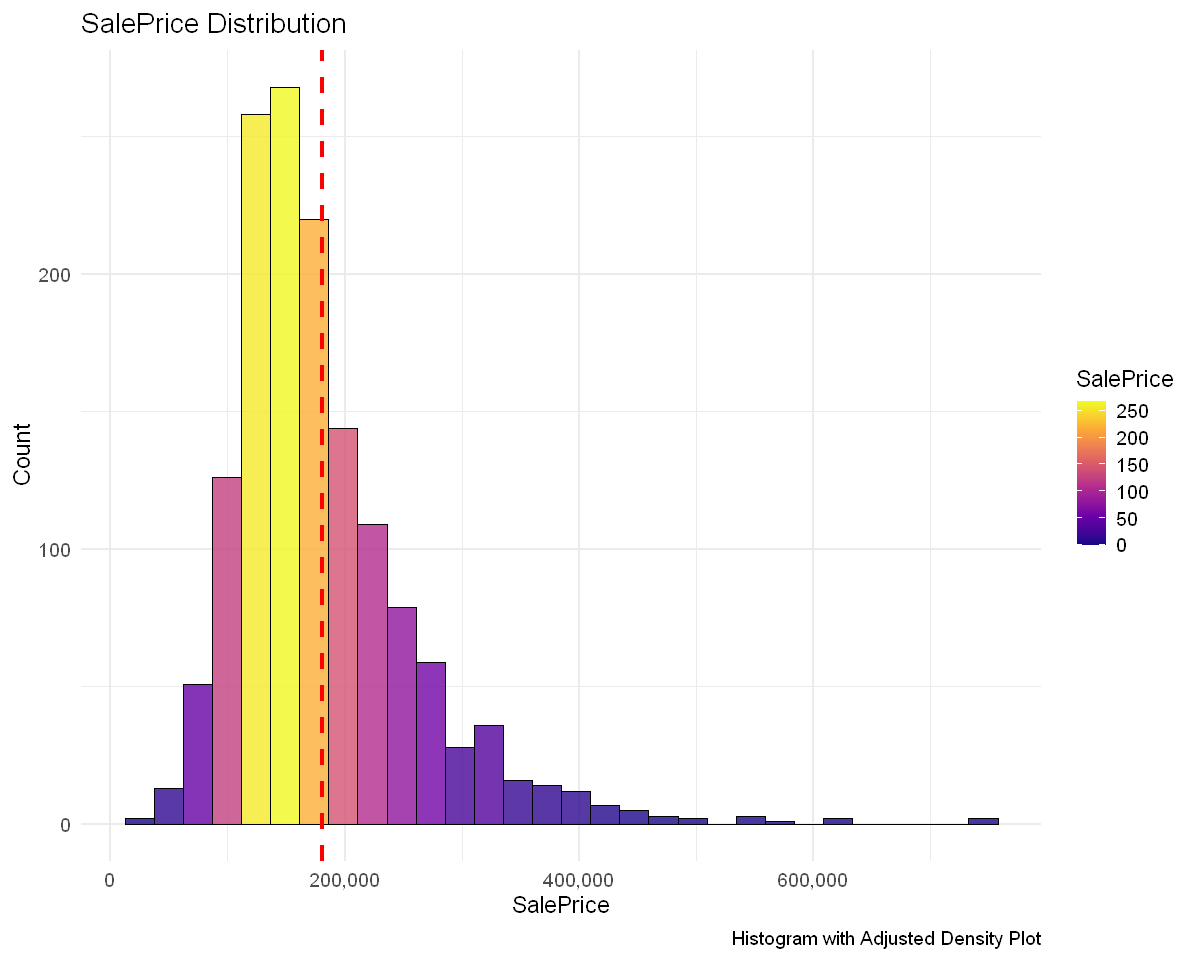

In [11]:
# Create a tibble with SalePrice
train %>%
  ggplot(aes(x = SalePrice)) +
  geom_histogram(aes(fill = after_stat(count)), bins = 30, color = "black", alpha = 0.8) +
  scale_fill_viridis_c(name = "SalePrice", option = "plasma") +
  geom_vline(
    aes(xintercept = mean(SalePrice, na.rm = TRUE)), 
    linetype = "dashed", linewidth = 1.2, color = "red"
  ) +
  scale_x_continuous(labels = comma_format()) +  # not use scientific notation
  labs(
    x = "SalePrice", 
    y = "Count",
    title = "SalePrice Distribution",
    caption = "Histogram with Adjusted Density Plot"
  ) +
  theme_minimal(base_size = 14)

In [12]:
# Calculate skewness and kurtosis
skewness_value <- skewness(train$SalePrice, na.rm = TRUE)
kurtosis_value <- kurtosis(train$SalePrice, na.rm = TRUE)

# Print skewness and kurtosis
cat("Skewness of SalePrice:", skewness_value, "\n")
cat("Kurtosis of SalePrice:", kurtosis_value, "\n")

Skewness of SalePrice: 1.879009 
Kurtosis of SalePrice: 6.496789 


From the histogram and the calculated value of skewness (1.88), we can see that the distribution of `SalePrice` is right-skewed. This may have a negative impact on the training of the model. So we need a log transformation for `SalePrice`.

In [13]:
# Log transformation of SalePrice
train <- train %>%
  mutate(SalePrice_log = log(SalePrice))

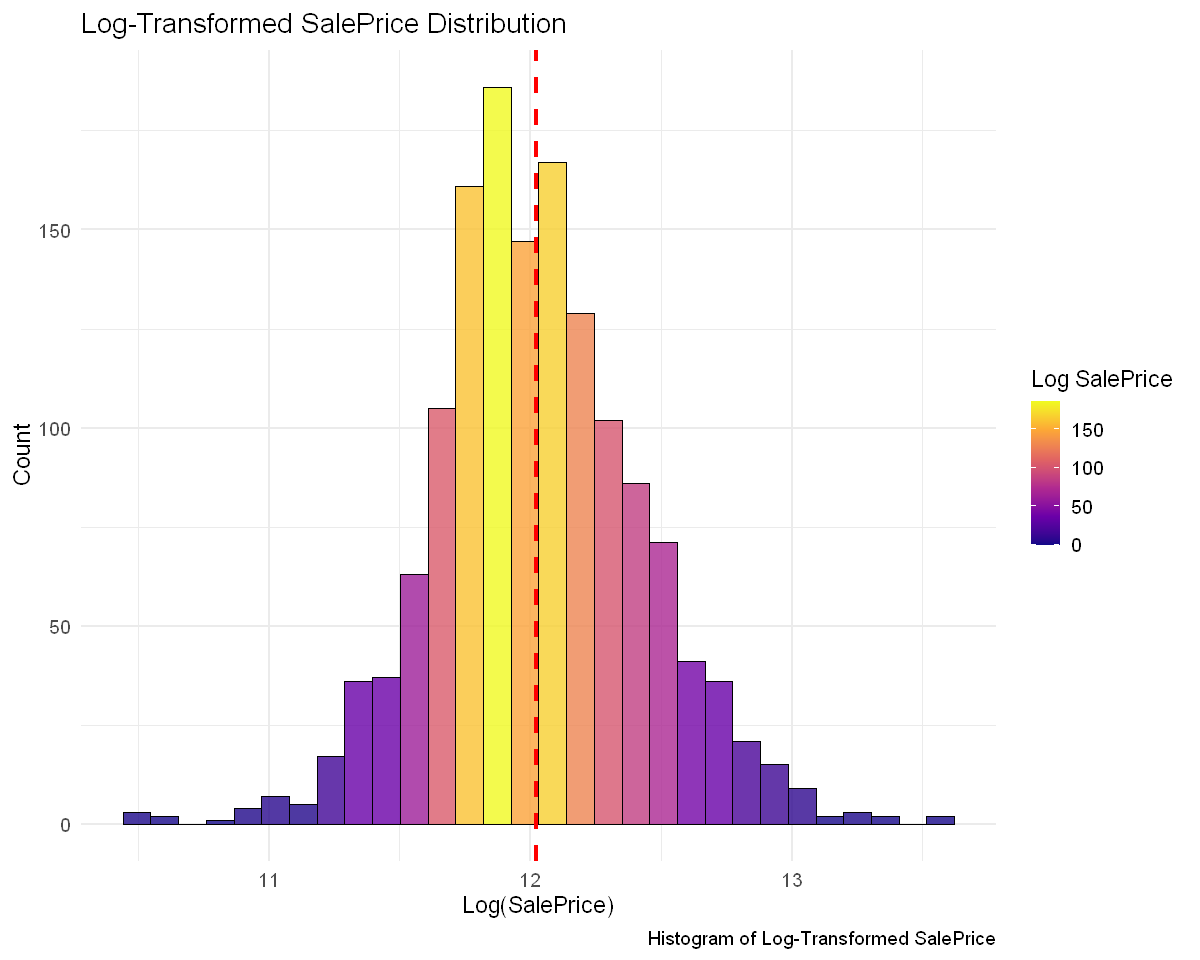

In [14]:
# Plot the distribution of log-transformed SalePrice
ggplot(train, aes(x = SalePrice_log)) +
  geom_histogram(aes(fill = after_stat(count)), bins = 30, color = "black", alpha = 0.8) +
  scale_fill_viridis_c(name = "Log SalePrice", option = "plasma") +
  geom_vline(
    aes(xintercept = mean(SalePrice_log, na.rm = TRUE)), 
    linetype = "dashed", linewidth = 1.2, color = "red"
  ) +
  scale_x_continuous(labels = comma_format()) +  # not use scientific notation
  labs(
    x = "Log(SalePrice)", 
    y = "Count",
    title = "Log-Transformed SalePrice Distribution",
    caption = "Histogram of Log-Transformed SalePrice"
  ) +
  theme_minimal(base_size = 14)

In [15]:
# Calculate skewness and kurtosis for log-transformed SalePrice
skewness_log <- skewness(train$SalePrice_log, na.rm = TRUE)
kurtosis_log <- kurtosis(train$SalePrice_log, na.rm = TRUE)

# Print skewness and kurtosis
cat("Log-Transformed SalePrice_log Skewness:", skewness_log, "\n")
cat("Log-Transformed SalePrice_log Kurtosis:", kurtosis_log, "\n")

Log-Transformed SalePrice_log Skewness: 0.1210859 
Log-Transformed SalePrice_log Kurtosis: 0.7974482 


From the charts and statistics, we can see that after logarithmic transformation, the distribution of `SalePrice` is closer to normal distribution.

In [16]:
# Remove the original SalePrice column
train <- train %>% select(-SalePrice)

The following is the distribution of the remaining numerical features:

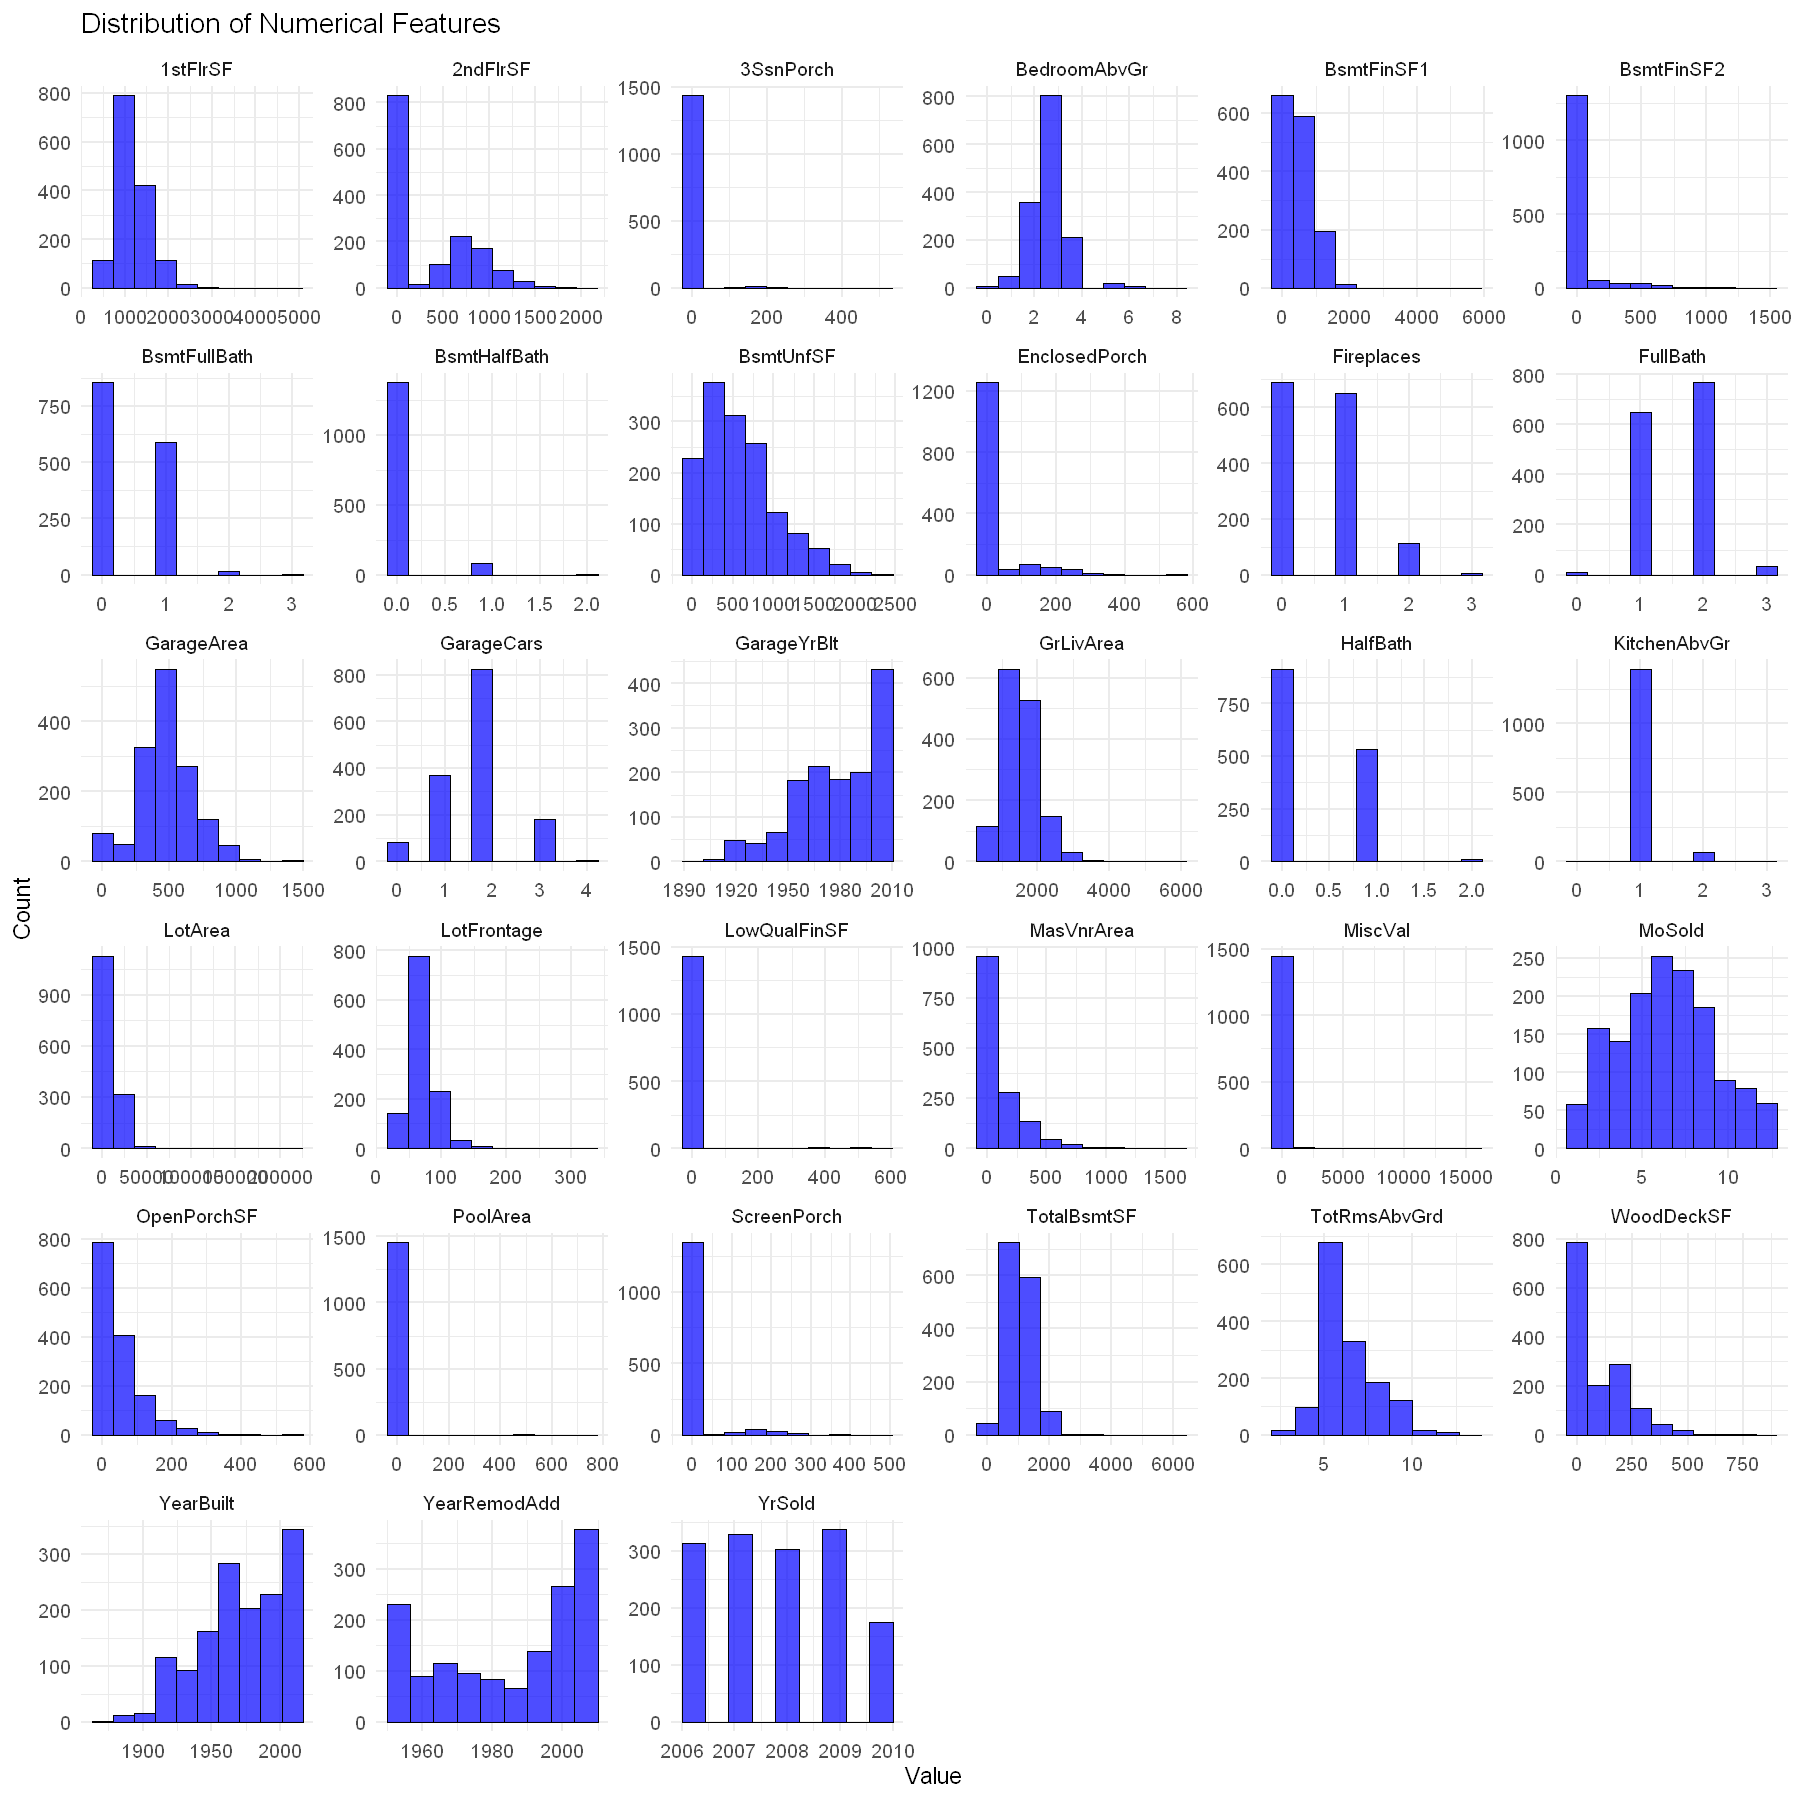

In [17]:
options(repr.plot.width = 15, repr.plot.height = 15)

# Convert train dataset to long format and remove NA/Inf values
train %>%
  select(all_of(numerical_features)) %>%
  pivot_longer(cols = everything(), names_to = "Feature", values_to = "Value") %>%
  filter(!is.na(Value) & is.finite(Value)) %>%  # Remove NA and Inf values

# Plot histograms for all numerical features
ggplot(aes(x = Value)) +
  geom_histogram(bins = 10, fill = "blue", color = "black", alpha = 0.7) +
  facet_wrap(~ Feature, scales = "free") +  # Free scales to adjust for different ranges
  labs(title = "Distribution of Numerical Features", x = "Value", y = "Count") +
  theme_minimal(base_size = 14)

## Feature Engineering

In [18]:
# Function to add features
add_features <- function(data, create_interactions = TRUE, create_base_features = TRUE) {
  # Create a new dataframe to store features
  new_features <- data.frame(row.names = rownames(data))
  
  # Base features
  if (create_base_features) {
    new_features$HouseAge <- data$YrSold - data$YearBuilt
    new_features$RemodelAge <- data$YrSold - data$YearRemodAdd
    new_features$TotalSF <- data$`1stFlrSF` + data$`2ndFlrSF` + data$TotalBsmtSF
  }
  
  # Merge new features into the original dataset
  data <- cbind(data, new_features)
  return(data)
}

In [19]:
# Apply feature engineering to train and test datasets
train <- add_features(train)
test <- add_features(test)

# Define new features
new_features <- c("HouseAge", "RemodelAge", "TotalSF")

# Update numerical_features list
numerical_features <- c(numerical_features, new_features)

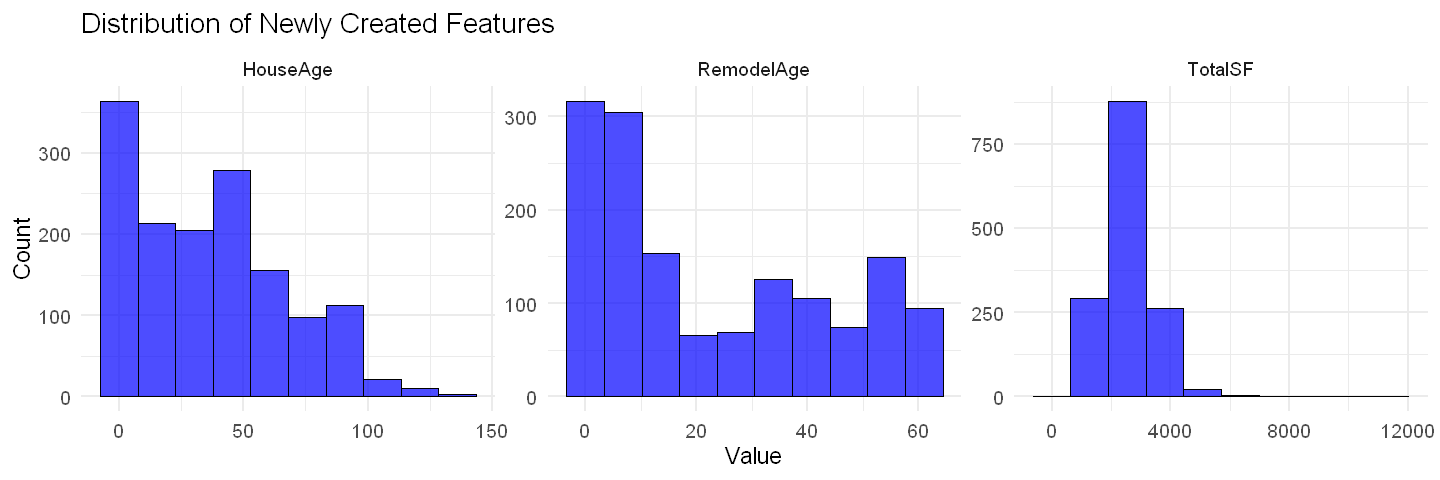

In [20]:
options(repr.plot.width = 12, repr.plot.height = 4)

# Plot histograms for new features
train %>%
  select(all_of(new_features)) %>%
  pivot_longer(cols = everything(), names_to = "Feature", values_to = "Value") %>%
  ggplot(aes(x = Value)) +
  geom_histogram(bins = 10, fill = "blue", color = "black", alpha = 0.7) +
  facet_wrap(~ Feature, scales = "free") +  
  labs(title = "Distribution of Newly Created Features", x = "Value", y = "Count") +
  theme_minimal(base_size = 14)

## Preprocessing

### Handling Missing Values

In [21]:
# Function to find columns with NA
check_na <- function(data) {
  na_count <- colSums(is.na(data))
  na_count <- sort(na_count[na_count > 0], decreasing = TRUE)  # Only keep columns with NA
  return(as.data.frame(na_count))
}

# Check missing values in train and test
na_train <- check_na(train)
na_test <- check_na(test)

# Print missing value summary
cat("Missing Values in Train Dataset:\n")
print(na_train)

cat("\nMissing Values in Test Dataset:\n")
print(na_test)

Missing Values in Train Dataset:
            na_count
LotFrontage      259
GarageYrBlt       81
MasVnrType         8
MasVnrArea         8
Electrical         1

Missing Values in Test Dataset:
             na_count
LotFrontage       227
GarageYrBlt        78
MasVnrType         16
MasVnrArea         15
MSZoning            4
Utilities           2
BsmtFullBath        2
BsmtHalfBath        2
Functional          2
Exterior1st         1
Exterior2nd         1
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
KitchenQual         1
GarageCars          1
GarageArea          1
SaleType            1
TotalSF             1


`NA` for these variables means the structure does not exist and should be filled with 0:

- `GarageYrBlt` (year garage was built)
- `MasVnrArea` (brick facing area)
- `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF` (basement area)
- `TotalBsmtSF` (total basement area)
- `GarageCars` (number of garage spaces)
- `GarageArea` (garage area)
- `TotalSF` (total area, usually equal to `1stFlrSF` + `2ndFlrSF` + `TotalBsmtSF`)

In [22]:
zero_fill_features <- c("GarageYrBlt", "MasVnrArea", "BsmtFinSF1", 
                        "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", 
                        "GarageCars", "GarageArea", "TotalSF")

train[zero_fill_features] <- lapply(train[zero_fill_features], function(x) replace(x, is.na(x), 0))
test[zero_fill_features] <- lapply(test[zero_fill_features], function(x) replace(x, is.na(x), 0))

`NA` for these variables may be missing data entries and should be filled with the most common category (Mode):

- `MasVnrType` (brickwork finish type)
- `Electrical` (electrical system)
- `MSZoning` (land zoning)
- `Utilities` (public facilities)
- `Functional` (house function)
- `Exterior1st`, `Exterior2nd` (exterior wall material)
- `KitchenQual` (kitchen quality)
- `SaleType` (sale type)

In [23]:
mode_fill_features <- c("MasVnrType", "Electrical", "MSZoning", 
                        "Utilities", "Functional", "Exterior1st", 
                        "Exterior2nd", "KitchenQual", "SaleType")

fill_mode <- function(x) {
  mode_value <- names(sort(table(x), decreasing = TRUE))[1]  # get mode
  replace(x, is.na(x), mode_value)
}

train[mode_fill_features] <- lapply(train[mode_fill_features], fill_mode)
test[mode_fill_features] <- lapply(test[mode_fill_features], fill_mode)

`NA` values for these variables may be missing values, and filling the median value can reduce the impact of outliers:

- `LotFrontage` (street frontage length)

In [24]:
train <- train %>%
  group_by(Neighborhood) %>%
  mutate(LotFrontage = ifelse(is.na(LotFrontage), median(LotFrontage, na.rm = TRUE), LotFrontage)) %>%
  ungroup()

test <- test %>%
  group_by(Neighborhood) %>%
  mutate(LotFrontage = ifelse(is.na(LotFrontage), median(LotFrontage, na.rm = TRUE), LotFrontage)) %>%
  ungroup()

Filled with 0 or 1 (integer feature)

- `BsmtFullBath`, `BsmtHalfBath` (basement bathrooms)

If there is no basement, the number of bathrooms should be 0.

In [25]:
bath_fill_features <- c("BsmtFullBath", "BsmtHalfBath")

train[bath_fill_features] <- lapply(train[bath_fill_features], function(x) replace(x, is.na(x), 0))
test[bath_fill_features] <- lapply(test[bath_fill_features], function(x) replace(x, is.na(x), 0))

Recheck `NA`

In [26]:
na_train_after <- check_na(train)
na_test_after <- check_na(test)

cat("After processing, missing values in Train Dataset:\n")
print(na_train_after)

cat("\nAfter processing, missing values in Test Dataset:\n")
print(na_test_after)

After processing, missing values in Train Dataset:
[1] na_count
<0 rows> (or 0-length row.names)

After processing, missing values in Test Dataset:
[1] na_count
<0 rows> (or 0-length row.names)


### Encoding

In [27]:
# Ensure test dataset has the same factor levels as train
for (col in categorical_features) {
  if (col %in% names(test)) {
    test[[col]] <- factor(test[[col]], levels = levels(train[[col]])) 
  }
}

# Apply One-Hot Encoding using predefined categorical_features
ohe <- dummyVars(~ ., data = train[, categorical_features])

# Apply transformation to train and test sets
train_ohe <- predict(ohe, train)
test_ohe <- predict(ohe, test)

# Merge transformed categorical features with numerical features
train <- cbind(train[, numerical_features], train_ohe, SalePrice_log = train$SalePrice_log)
test <- cbind(test[, numerical_features], test_ohe)

# Ensure all variables are numeric
str(train)

'data.frame':	1460 obs. of  337 variables:
 $ LotFrontage          : num  65 80 68 60 84 85 75 80 51 50 ...
 $ LotArea              : num  8450 9600 11250 9550 14260 ...
 $ YearBuilt            : num  2003 1976 2001 1915 2000 ...
 $ YearRemodAdd         : num  2003 1976 2002 1970 2000 ...
 $ MasVnrArea           : num  196 0 162 0 350 0 186 240 0 0 ...
 $ BsmtFinSF1           : num  706 978 486 216 655 ...
 $ BsmtFinSF2           : num  0 0 0 0 0 0 0 32 0 0 ...
 $ BsmtUnfSF            : num  150 284 434 540 490 64 317 216 952 140 ...
 $ TotalBsmtSF          : num  856 1262 920 756 1145 ...
 $ 1stFlrSF             : num  856 1262 920 961 1145 ...
 $ 2ndFlrSF             : num  854 0 866 756 1053 ...
 $ LowQualFinSF         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ GrLivArea            : num  1710 1262 1786 1717 2198 ...
 $ BsmtFullBath         : num  1 0 1 1 1 1 1 1 0 1 ...
 $ BsmtHalfBath         : num  0 1 0 0 0 0 0 0 0 0 ...
 $ FullBath             : num  2 2 2 1 2 1 2 2 2 1 ...
 $ HalfBath 

### Normalize Data (Standard Scaling)

In [28]:
# Apply Standard Scaling (Z-score normalization)
scaler <- preProcess(train[, numerical_features], method = c("center", "scale"))

# Normalize train and test datasets
train[, numerical_features] <- predict(scaler, train[, numerical_features])
test[, numerical_features] <- predict(scaler, test[, numerical_features])

# Check summary to confirm scaling
summary(train[, numerical_features])

  LotFrontage           LotArea          YearBuilt         YearRemodAdd    
 Min.   :-2.193290   Min.   :-0.9234   Min.   :-3.28670   Min.   :-1.6888  
 1st Qu.:-0.454694   1st Qu.:-0.2969   1st Qu.:-0.57173   1st Qu.:-0.8654  
 Median :-0.008901   Median :-0.1040   Median : 0.05735   Median : 0.4424  
 Mean   : 0.000000   Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.: 0.436893   3rd Qu.: 0.1087   3rd Qu.: 0.95131   3rd Qu.: 0.9268  
 Max.   :10.823886   Max.   :20.5112   Max.   : 1.28240   Max.   : 1.2174  
   MasVnrArea        BsmtFinSF1        BsmtFinSF2        BsmtUnfSF      
 Min.   :-0.5706   Min.   :-0.9727   Min.   :-0.2886   Min.   :-1.2837  
 1st Qu.:-0.5706   1st Qu.:-0.9727   1st Qu.:-0.2886   1st Qu.:-0.7791  
 Median :-0.5706   Median :-0.1319   Median :-0.2886   Median :-0.2031  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.3383   3rd Qu.: 0.5889   3rd Qu.:-0.2886   3rd Qu.: 0.5449  
 Max.   : 8.2824   Max.   :11.

## Modeling

### kNN

In [29]:
# Define training control
control <- trainControl(method = "cv", number = 5)

# Train KNN model (search for best k from 3 to 20)
set.seed(123)
knn_model <- train(SalePrice_log ~ ., 
                   data = train, 
                   method = "knn", 
                   trControl = control, 
                   tuneGrid = expand.grid(k = seq(2, 20, by = 1)))  

In [30]:
knn_model

k-Nearest Neighbors 

1460 samples
 336 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1169, 1169, 1167, 1168, 1167 
Resampling results across tuning parameters:

  k   RMSE       Rsquared   MAE      
   2  0.1845686  0.7900069  0.1276179
   3  0.1817196  0.7983125  0.1230549
   4  0.1792032  0.8048398  0.1211112
   5  0.1774886  0.8093004  0.1202619
   6  0.1758587  0.8133593  0.1193890
   7  0.1756505  0.8148392  0.1200586
   8  0.1755424  0.8161537  0.1199109
   9  0.1751004  0.8183383  0.1195764
  10  0.1743246  0.8207036  0.1192279
  11  0.1738102  0.8230655  0.1188269
  12  0.1732819  0.8249960  0.1188608
  13  0.1733773  0.8248139  0.1191312
  14  0.1733588  0.8257621  0.1195074
  15  0.1733005  0.8260253  0.1194859
  16  0.1735761  0.8261160  0.1197313
  17  0.1740310  0.8254902  0.1197519
  18  0.1740578  0.8256934  0.1201630
  19  0.1739952  0.8268467  0.1202297
  20  0.1741199  0.8273405  0.1204882

RMSE was used to select the opt

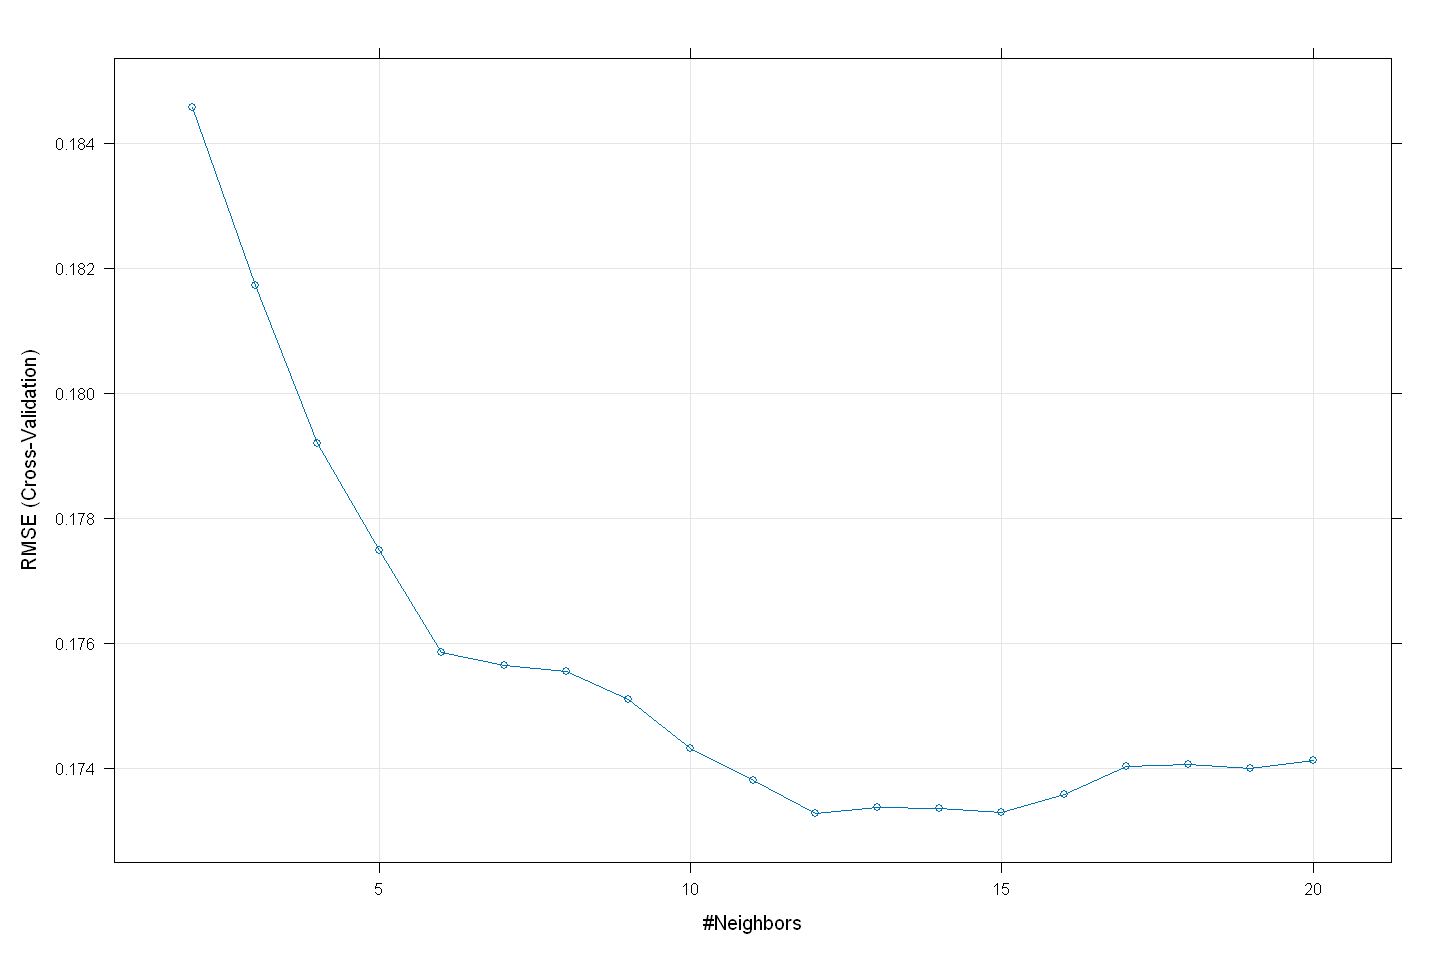

In [31]:
options(repr.plot.width = 12, repr.plot.height = 8)
plot(knn_model)

### SVM

In [32]:
# Train SVM model with radial basis function (RBF) kernel
set.seed(123)
svm_model <- train(SalePrice_log ~ ., 
                   data = train, 
                   method = "svmRadial", 
                   trControl = control, 
                   tuneLength = 5)  # Automatically searches for best parameters

Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x, ...):
"Variable(s) `' constant. Cannot scale data."
Warning message in .local(x,

In [33]:
svm_model

Support Vector Machines with Radial Basis Function Kernel 

1460 samples
 336 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1169, 1169, 1167, 1168, 1167 
Resampling results across tuning parameters:

  C     RMSE       Rsquared   MAE       
  0.25  0.1400580  0.8793136  0.09348299
  0.50  0.1332413  0.8900571  0.08837307
  1.00  0.1290501  0.8962326  0.08551372
  2.00  0.1262895  0.9005448  0.08413747
  4.00  0.1250289  0.9023650  0.08437091

Tuning parameter 'sigma' was held constant at a value of 0.002345221
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were sigma = 0.002345221 and C = 4.

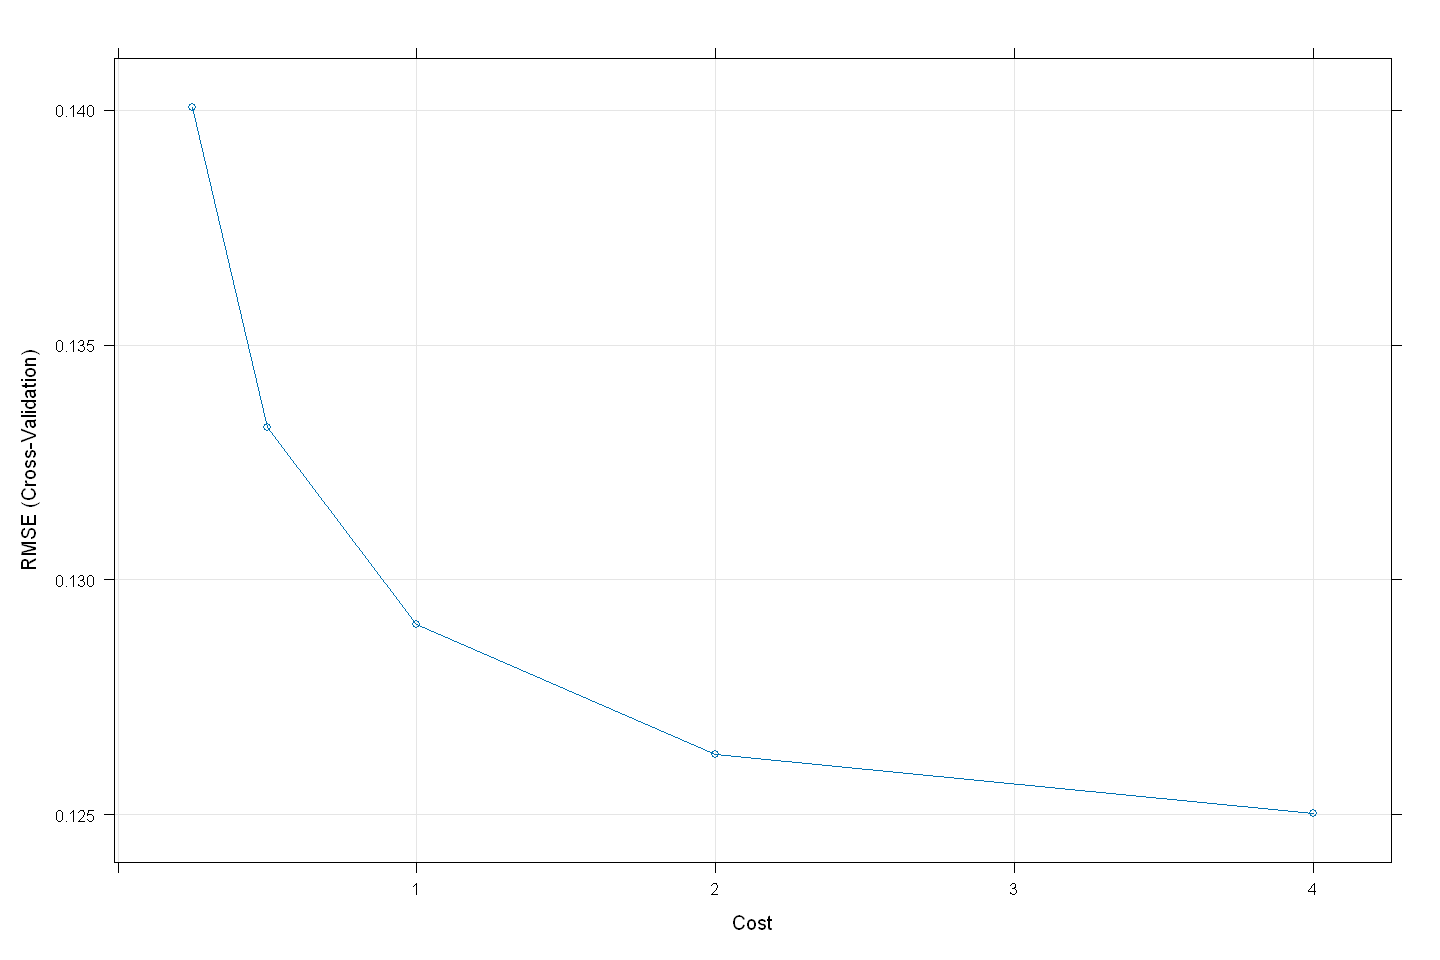

In [34]:
plot(svm_model)

### Linear Regression

In [35]:
# Train Linear Regression model
set.seed(123)
lr_model <- train(SalePrice_log ~ ., 
                  data = train, 
                  method = "lm", 
                  trControl = control)

Warning message in predict.lm(modelFit, newdata):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in predict.lm(modelFit, newdata):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in predict.lm(modelFit, newdata):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in predict.lm(modelFit, newdata):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in predict.lm(modelFit, newdata):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


In [36]:
lr_model

Linear Regression 

1460 samples
 336 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1169, 1169, 1167, 1168, 1167 
Resampling results:

  RMSE       Rsquared   MAE       
  0.1662427  0.8343093  0.09405306

Tuning parameter 'intercept' was held constant at a value of TRUE

### Lasso

In [37]:
# Convert train and test to matrices for glmnet
x_train <- as.matrix(train[, numerical_features])
y_train <- train$SalePrice_log
x_test <- as.matrix(test[, numerical_features])

In [38]:
# Train Lasso Regression (alpha = 1)
set.seed(123)
lasso_model <- cv.glmnet(x_train, y_train, alpha = 1)

In [39]:
lasso_model


Call:  cv.glmnet(x = x_train, y = y_train, alpha = 1) 

Measure: Mean-Squared Error 

     Lambda Index Measure       SE Nonzero
min 0.00568    44 0.03272 0.006926      24
1se 0.04829    21 0.03901 0.005492       7

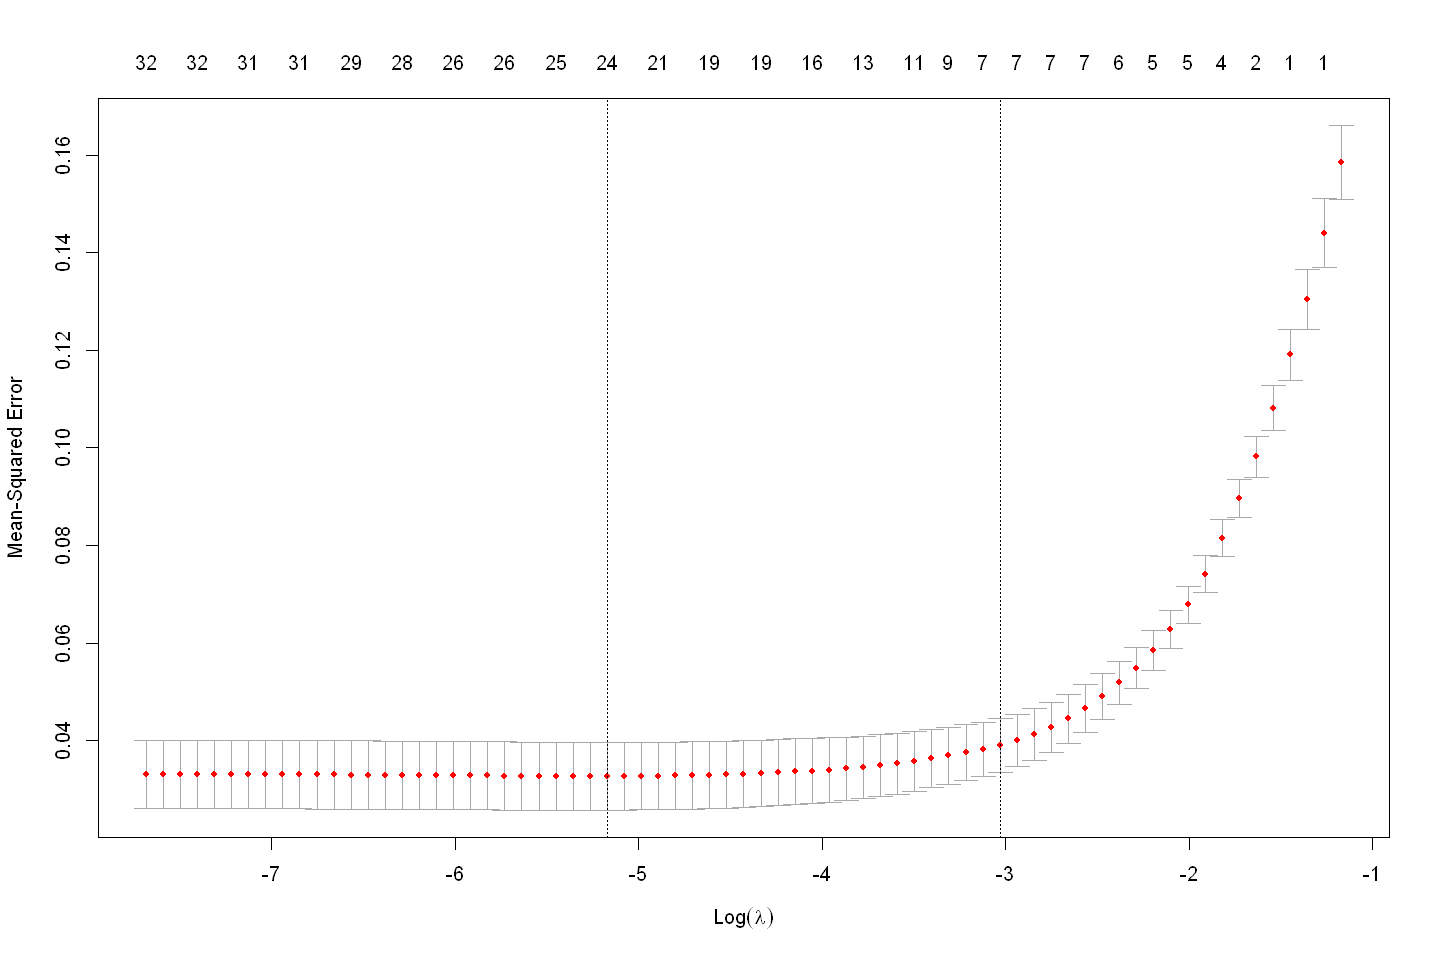

In [40]:
plot(lasso_model)

### Ridge

In [41]:
# Train Ridge Regression (alpha = 0)
set.seed(123)
ridge_model <- cv.glmnet(x_train, y_train, alpha = 0)

In [42]:
ridge_model


Call:  cv.glmnet(x = x_train, y = y_train, alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure       SE Nonzero
min 0.1375    84 0.03218 0.006231      36
1se 0.8840    64 0.03831 0.004226      36

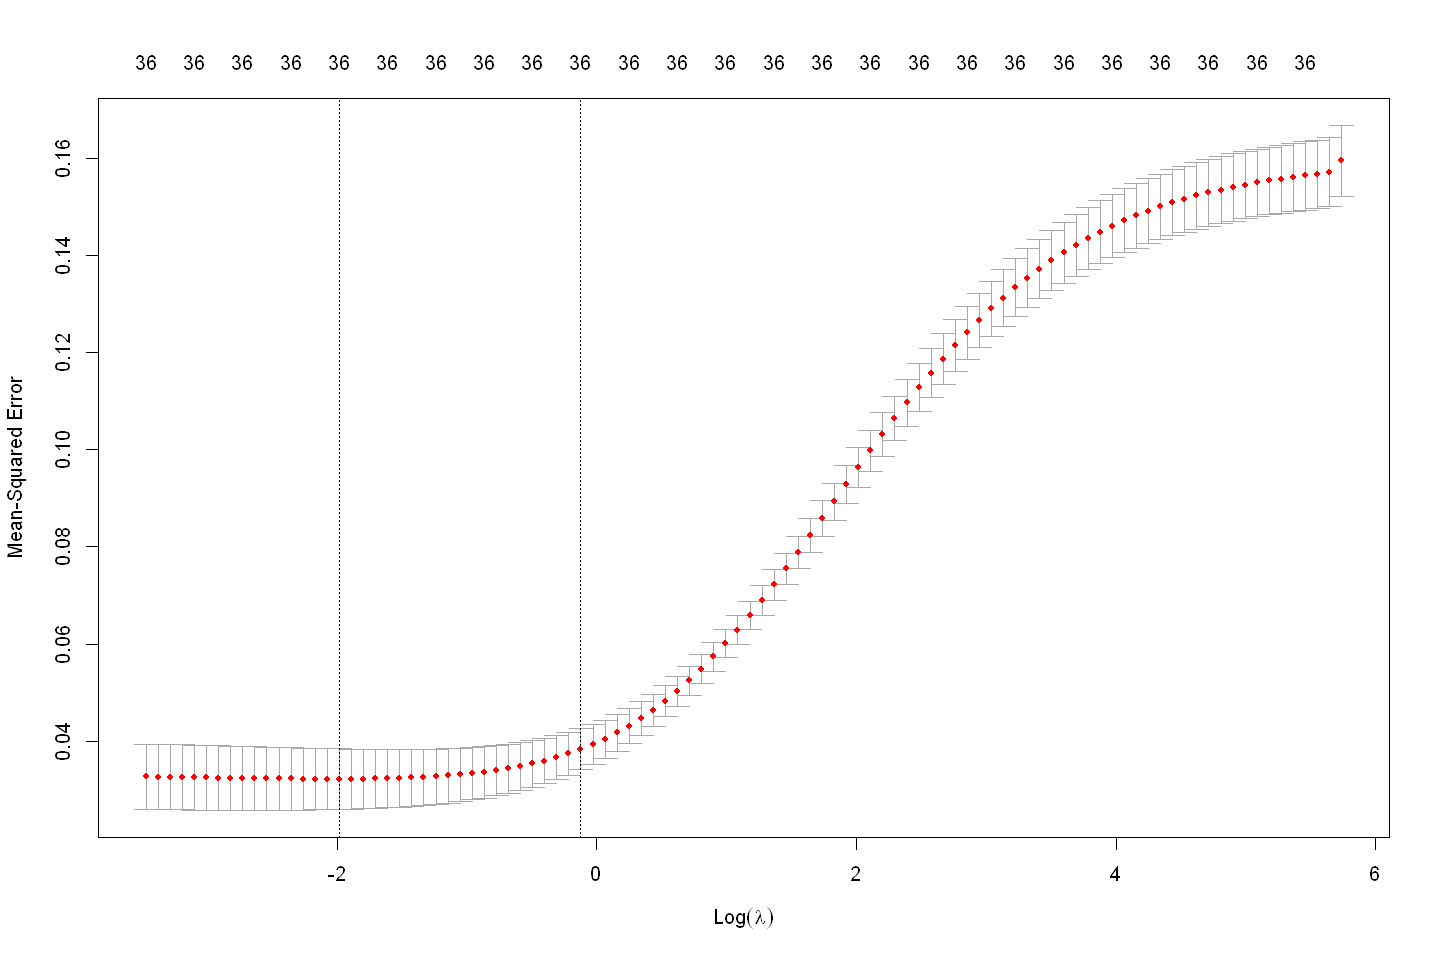

In [43]:
plot(ridge_model)

### ElasticNet

In [44]:
# Train Elastic Net (alpha = 0.5)
set.seed(123)
elastic_model <- cv.glmnet(x_train, y_train, alpha = 0.5)

In [45]:
elastic_model


Call:  cv.glmnet(x = x_train, y = y_train, alpha = 0.5) 

Measure: Mean-Squared Error 

     Lambda Index Measure       SE Nonzero
min 0.01247    43 0.03261 0.006788      26
1se 0.08799    22 0.03871 0.005006      11

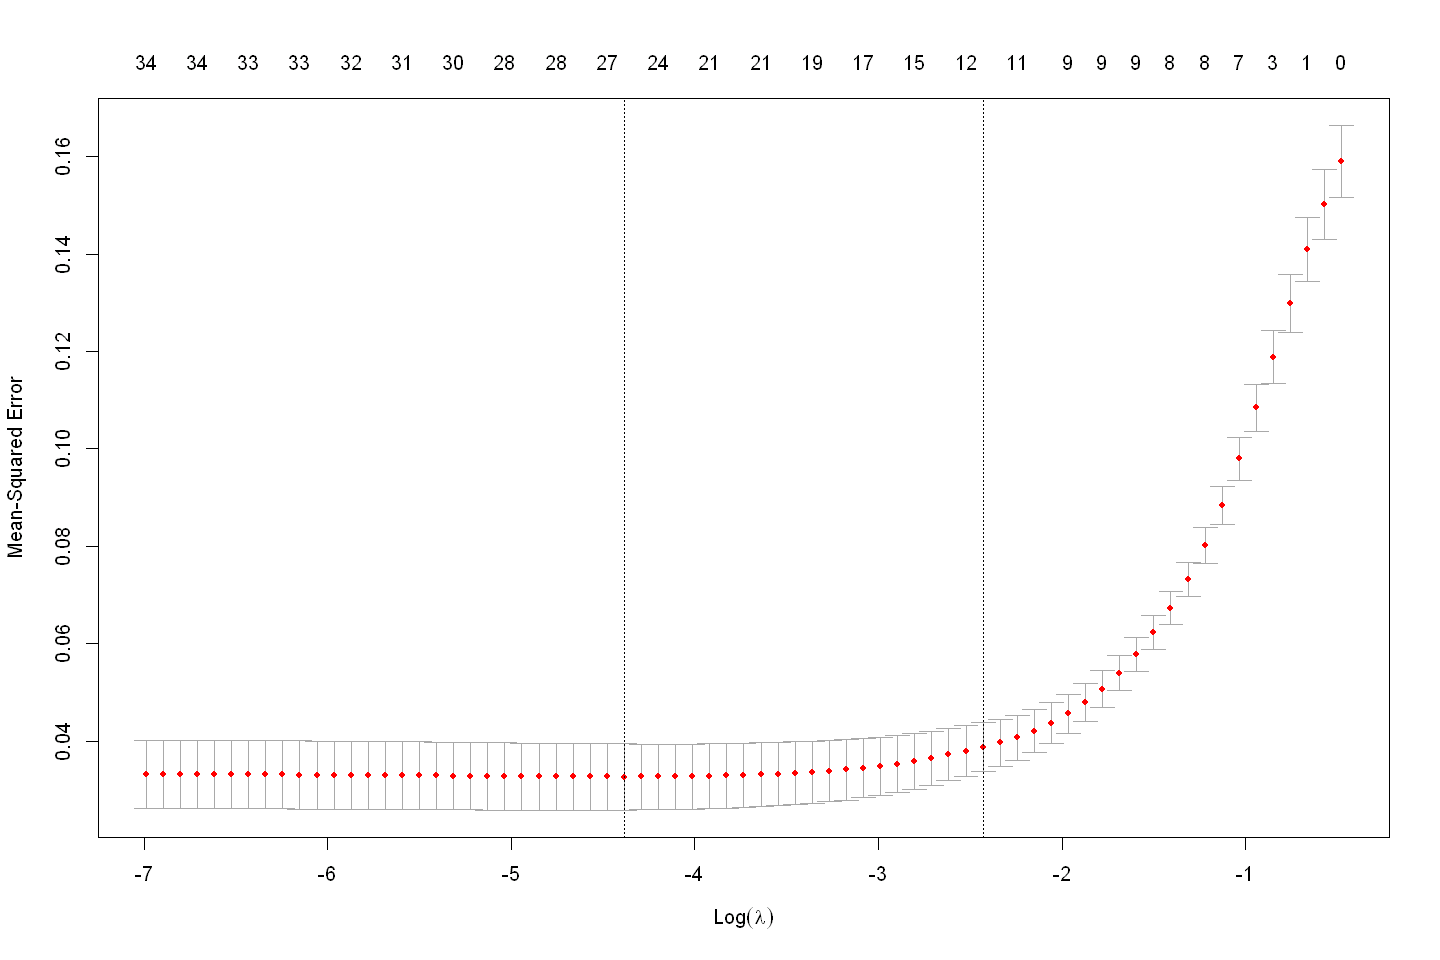

In [46]:
plot(elastic_model)

### Decision Tree

In [47]:
# Ensure all features are included in the model
feature_names <- setdiff(names(train), c("Id", "SalePrice"))

# Train Decision Tree
set.seed(123)
dt_model <- train(
  x = train[, feature_names], 
  y = train$SalePrice_log, 
  method = "rpart", 
  trControl = trainControl(method = "cv", number = 5),
  tuneLength = 10
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


In [48]:
dt_model

CART 

1460 samples
 337 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1169, 1169, 1167, 1168, 1167 
Resampling results across tuning parameters:

  cp           RMSE        Rsquared   MAE       
  0.004123256  0.07073209  0.9686293  0.05436392
  0.005264440  0.07425451  0.9656958  0.05690558
  0.008289932  0.08013962  0.9603042  0.06132646
  0.020787158  0.09946534  0.9381319  0.07938158
  0.022259562  0.11308238  0.9195754  0.09419376
  0.024627884  0.13180918  0.8911292  0.10581696
  0.027539374  0.14621217  0.8661460  0.11297063
  0.125213917  0.18400717  0.7822614  0.13835935
  0.132022391  0.23497255  0.6537036  0.17884794
  0.604412897  0.34101599  0.5841747  0.26478954

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.004123256.

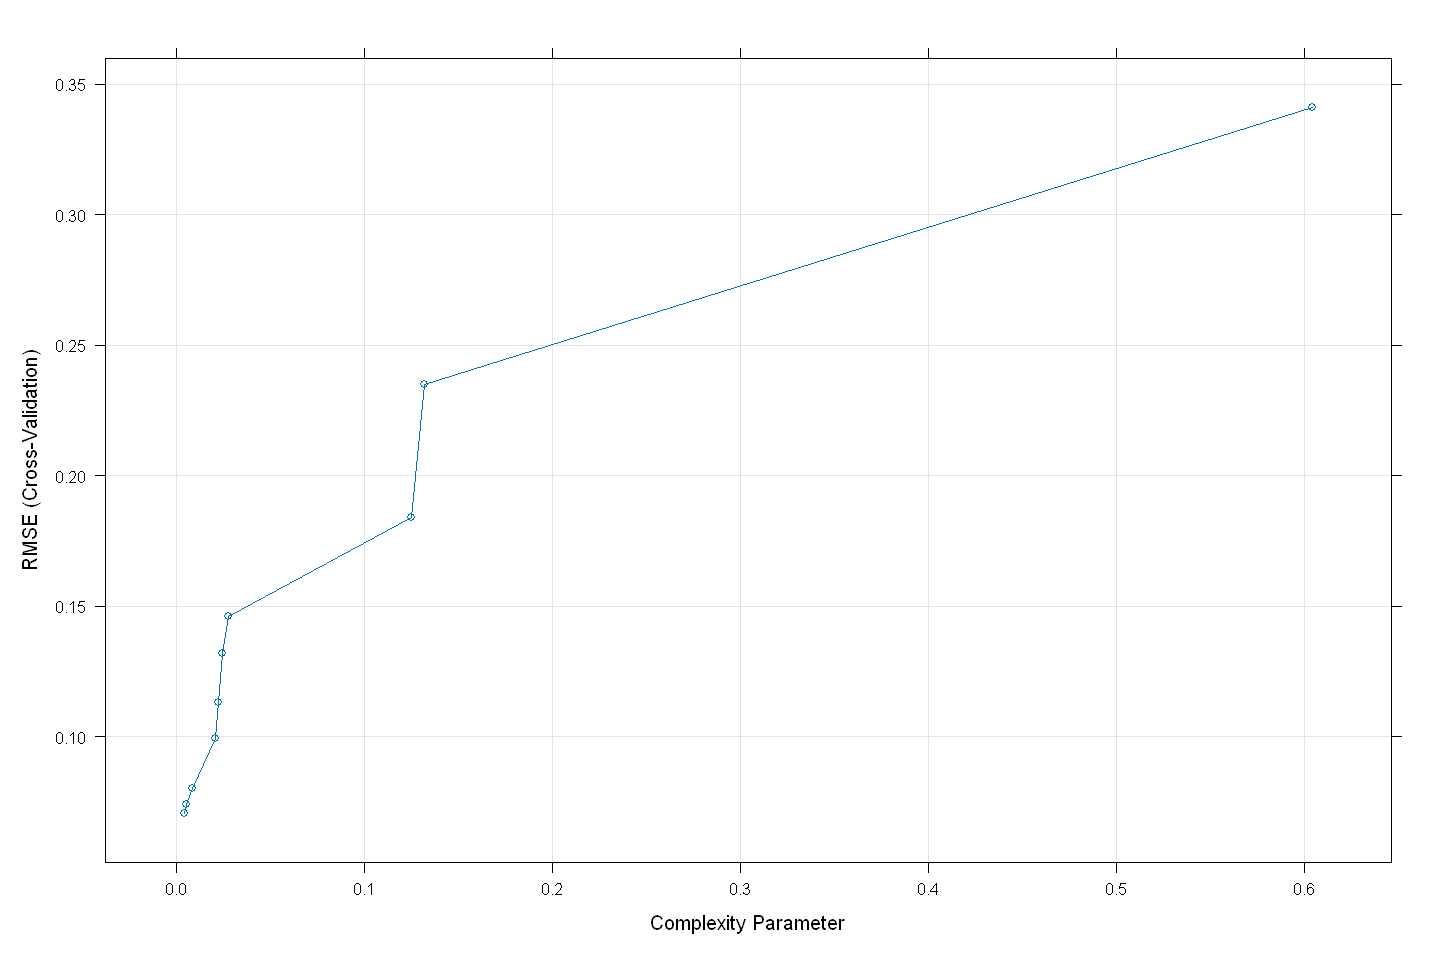

In [49]:
plot(dt_model)

### Bagging

In [50]:
# Ensure all features are included in the model
feature_names <- setdiff(names(train), c("Id", "SalePrice"))

# Train Bagging model (explicit feature selection)
set.seed(123)
bagging_model <- train(
  x = train[, feature_names], 
  y = train$SalePrice_log, 
  method = "treebag", 
  trControl = trainControl(method = "cv", number = 5)
)

In [51]:
bagging_model

Bagged CART 

1460 samples
 337 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1169, 1169, 1167, 1168, 1167 
Resampling results:

  RMSE        Rsquared  MAE       
  0.05952973  0.978507  0.04010522


### Random Forest

In [52]:
# Train Random Forest model
set.seed(123)
rf_model <- train(SalePrice_log ~ ., 
                  data = train, 
                  method = "rf", 
                  trControl = control,
                  tuneGrid = expand.grid(mtry = seq(3, floor(sqrt(ncol(train) - 1)), 2)), 
                  ntree = 500)  # Optimize mtry and use 500 trees

In [53]:
rf_model

Random Forest 

1460 samples
 336 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1169, 1169, 1167, 1168, 1167 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE       
   3    0.1925098  0.8343472  0.13232173
   5    0.1675364  0.8586295  0.11228565
   7    0.1588777  0.8668822  0.10547821
   9    0.1527855  0.8735186  0.10111837
  11    0.1501170  0.8758326  0.09898017
  13    0.1484744  0.8771772  0.09755836
  15    0.1467841  0.8788165  0.09687788
  17    0.1455728  0.8795109  0.09601605

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 17.

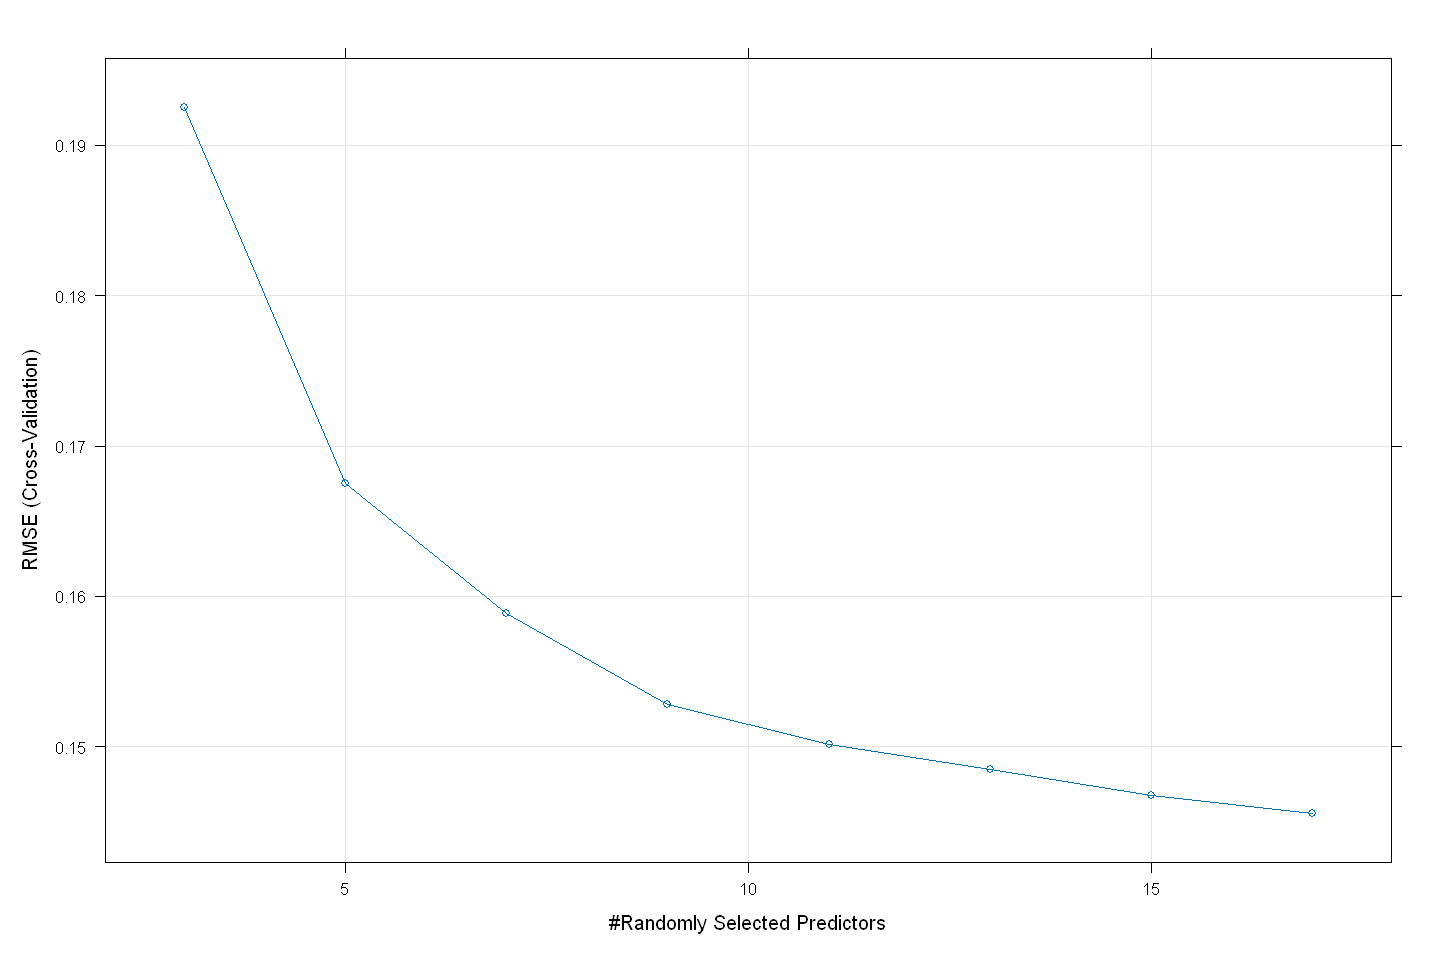

In [54]:
plot(rf_model)

### XGBoost

In [55]:
# Define XGBoost parameters
params <- list(
  objective = "reg:squarederror",  # Regression task
  eval_metric = "rmse",            # Root Mean Squared Error
  eta = 0.05,                      # Learning rate
  max_depth = 6,                   # Tree depth
  subsample = 0.8,                 # Row sampling
  colsample_bytree = 0.8           # Feature sampling
)

# Convert data to XGBoost format
dtrain <- xgb.DMatrix(data = x_train, label = y_train)
dtest <- xgb.DMatrix(data = x_test)

# Use cross-validation to determine `nrounds`
set.seed(123)
cv_results <- xgb.cv(
  params = params,
  data = dtrain,
  nrounds = 500,  # Start with a reasonable upper bound
  nfold = 5,  # 5-fold cross-validation
  early_stopping_rounds = 20,  # Stop if no improvement
  verbose = TRUE
)

# Extract best `nrounds`
best_nrounds <- cv_results$best_iteration
cat("Best nrounds:", best_nrounds, "\n")

# Train final model with best `nrounds`
xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = best_nrounds,
  verbose = 1
)

[1]	train-rmse:10.955906+0.006319	test-rmse:10.955914+0.027053 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 20 rounds.

[2]	train-rmse:10.409415+0.006180	test-rmse:10.409422+0.027204 
[3]	train-rmse:9.890327+0.005956	test-rmse:9.890333+0.027426 
[4]	train-rmse:9.397029+0.005689	test-rmse:9.397033+0.027701 
[5]	train-rmse:8.928634+0.005263	test-rmse:8.928637+0.028144 
[6]	train-rmse:8.483707+0.005180	test-rmse:8.483707+0.028224 
[7]	train-rmse:8.061160+0.004857	test-rmse:8.061159+0.028549 
[8]	train-rmse:7.659444+0.004582	test-rmse:7.659663+0.028553 
[9]	train-rmse:7.277962+0.004365	test-rmse:7.278175+0.028455 
[10]	train-rmse:6.915648+0.004193	test-rmse:6.916309+0.028504 
[11]	train-rmse:6.571441+0.004101	test-rmse:6.572028+0.028034 
[12]	train-rmse:6.244302+0.003866	test-rmse:6.244799+0.027293 
[13]	train-rmse:5.933583+0.003644	test-rmse:5.934007+0.027001 
[14]	train-rmse:5.638300+0.003609	test-rmse:5.638459+0

## References

- Kaggle Competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
- Dataset Description: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data